# Principled Amortized Bayesian Workflow for Cognitive Modeling
by Lukas Schumacher 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generative-Model-Definition" data-toc-modified-id="Generative-Model-Definition-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generative Model Definition</a></span><ul class="toc-item"><li><span><a href="#Creating-a-Simulator" data-toc-modified-id="Creating-a-Simulator-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating a Simulator</a></span></li><li><span><a href="#Defining-Prior-Distributions" data-toc-modified-id="Defining-Prior-Distributions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Defining Prior Distributions</a></span></li><li><span><a href="#Context" data-toc-modified-id="Context-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Context</a></span></li><li><span><a href="#Simulator" data-toc-modified-id="Simulator-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Simulator</a></span></li></ul></li><li><span><a href="#Prior-Push-Forward-Check" data-toc-modified-id="Prior-Push-Forward-Check-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prior Push Forward Check</a></span></li><li><span><a href="#Defining-the-Neural-Approximator" data-toc-modified-id="Defining-the-Neural-Approximator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Defining the Neural Approximator</a></span><ul class="toc-item"><li><span><a href="#Summary-Network" data-toc-modified-id="Summary-Network-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Summary Network</a></span></li><li><span><a href="#Inference-Network" data-toc-modified-id="Inference-Network-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Inference Network</a></span></li><li><span><a href="#Amortized-Posterior" data-toc-modified-id="Amortized-Posterior-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Amortized Posterior</a></span></li></ul></li><li><span><a href="#Defining-the-Configurator" data-toc-modified-id="Defining-the-Configurator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Defining the Configurator</a></span></li><li><span><a href="#Defining-the-Trainer" data-toc-modified-id="Defining-the-Trainer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Defining the Trainer</a></span></li><li><span><a href="#Training-Phase" data-toc-modified-id="Training-Phase-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training Phase</a></span><ul class="toc-item"><li><span><a href="#Inspecting-the-Loss" data-toc-modified-id="Inspecting-the-Loss-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Inspecting the Loss</a></span></li><li><span><a href="#Inspecting-the-Latent-Space" data-toc-modified-id="Inspecting-the-Latent-Space-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Inspecting the Latent Space</a></span></li></ul></li><li><span><a href="#Prior-Predictive-Checks" data-toc-modified-id="Prior-Predictive-Checks-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prior Predictive Checks</a></span></li><li><span><a href="#Simulation-Based-Calibration" data-toc-modified-id="Simulation-Based-Calibration-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Simulation-Based Calibration</a></span><ul class="toc-item"><li><span><a href="#Rank-Histograms" data-toc-modified-id="Rank-Histograms-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Rank Histograms</a></span></li><li><span><a href="#Rank-ECDF" data-toc-modified-id="Rank-ECDF-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Rank ECDF</a></span></li></ul></li><li><span><a href="#Inferential-Adequacy" data-toc-modified-id="Inferential-Adequacy-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Inferential Adequacy</a></span></li><li><span><a href="#Inference-Phase" data-toc-modified-id="Inference-Phase-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Inference Phase</a></span></li></ul></div>

In [ ]:
import numpy as np
import seaborn as sns
import bayesflow as bf
import tensorflow as tf

In [2]:
try:
    from numba import njit
except ModuleNotFoundError as err:
    print('Please run `pip install numba` for utilizing just-in-time compilation.')

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

## Introduction

Psychological research often relies on mathematical models to explain and predict human behavior.
Such models aim to formalize cognitive processes by mapping latent psychological constructs to model parameters and specifying how these generate manifest data. In this tutorial, we go through the steps of a principled [Bayesian workflow](https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html) that is imperative when developing and applying cognitive models.
This workflow includes the following steps:

1. Prior pushforward and prior predictive checks to assess whether the model is consistent with our domain expertise
2. Computational faithfulness to ensure that our estimation method can accurately fit the posterior distributions
3. Inferential calibration to examine if our inferences provide sufficient information for answering our research question
4. Posterior retrodiction checks to assess whether our model can capture the relevant structure of the true data generating process

To demonstrate how such a workflow is performed with BayesFlow, we will use an exemplar model from the evidence accumulaton model family.

## Generative Model Definition

Evidence accumulation models (EAM) are among the most commonly used cognitive models in psychological research. These decision models account for both choice and response time data by assuming that agents accumulate evidence for decision alternatives until a threshold is reached. This process is typically formalized as a random walk with drift. The standard EAM has four core parameters, each corresponding to a specific latent cognitive construct: i) the drift rate $v$ represents mental processing speed; ii) the threshold $a$ reflects decision caution; iii) the starting point $\beta$ determines decisional biases, and iv) the non-decision time $\tau$ accounts for decision-unrelated processes such as motor actions and perceptual encoding.

There are many model variations within the EAM class. Througout this tutorial, we will focus on the leaky competing accumulator (LCA) model proposed by [Usher and McClelland (2001)](https://psycnet.apa.org/record/2001-07628-003). The likelihood function of this model is not known in closed form. This makes it a perfect candidate for <tt>BayesFlow</tt>, as it can handle any model that can be implemented as a randomized data simulator.

The LCA assumes a competition between seperate accumulators $A$, each corresponding to an decision alternative $j$. The accumulator $A_j$ that first hits its threshold wins and the corresponding decision will be made. Evidence accumulation for a certain decision alternative follows a Wiener process with two additional features: i) evidence leakage or decay $\lambda$ that accounts for information loss over time within each accumulator, and ii) lateral inhibition $\kappa$, which represents accumulator activation damping from the other accumulators. The activiation of a single accumulator $x_j$ is thus updated as follow:

$$
\begin{align}
\mathrm{d}x_j &= \left(v_j - \lambda x_j - \kappa \sum_{j'\neq j} x_{j'}\right)\mathrm{d}t + \xi \sqrt{\mathrm{d}t}
\quad\text{with}\quad \xi\sim\mathcal{N}(0, 1)\\
x_j &=\mathrm{max}(x_j, 0)
\end{align}
$$

This process continues until one of the accumulator's activations exceeds a fixed threshold $a$. The decision corresponding to the accumulator that reached its threshold first will be made. The first-passage time, summed with a constant $\tau$ for non-decisional processes, determines the response time. For simplicity, we assume that all accumulators start at $0$, so we do not account for an a priori bias towards a particular decision alternative. Thus, our LCA version has the following free parameters:

* Drift rates $v$
* Threshold $a$
* Non-decision time $\tau$
* Decay $\lambda$
* Inhibition $\kappa$

### Creating a Simulator

Now, let us specify the LCA as a randomized data simulator. For this function we use the `@njit` decorator from the [Numba](https://numba.pydata.org/) module to speed up computing time.

In [4]:
@njit
def lca_trial(v, a, ndt, la, ka, dt=1e-3, s=1.0, max_iter=1e5):
    """Generates a response time and choice from the LCA model given a set of parameters"""
    # get number of decision alternatives
    n_alt = len(v)
    # constant for diffusion process
    c = np.sqrt(dt * s)
    # initialize accumulator activities
    x = np.zeros(n_alt)
    # accumulation process
    n_iter = 0
    while np.all(x < a) and n_iter < max_iter:
        # iterate over accumulators
        for i in range(n_alt):
            x[i] = max(0.0, (x[i] + (v[i] - la*x[i] - ka*(np.sum(x)-x[i]))*dt + c*np.random.randn()))
        n_iter += 1
    # determine respnose time and choice
    rt = n_iter*dt + ndt
    if n_iter < max_iter:
        resp = float(np.where(x >= a)[0][0])
    else:
        resp = -1.0

    return rt, resp

This function returns a single response time and choice. It is generally written and can be used for all decisions between two or more alternatives. Let's test it in the case of three alterantives with some randomly chosen parameter values.

In [7]:
rt, resp = lca_trial(v=np.array([1, 1, 1]), a=1.5, ndt=0.3, la=0.1, ka=0.1)
print(rt, resp)

0.857 2.0


### Defining Prior Distributions

Next, we specify prior distributions for the LCA parameters. We want to bound all the parameters to possible values. We also want that most of the mass of the prior distributions lies on plausible values we know from domain expertice. All LCA parameters should be positive values. The leak and decay parameter are further bounded to $1$. Thus, we use Gamma distributions for the drift rates, threshold, and non-decision time. For the leak and decay parameter we use Beta distributions.

Further down we will create an experimental context for a hypothetical decision making task between three alternatives and two conditions. Let us imagine that the experimental manipulation is expected to affect only the drift rates. Thus, we need three drift rates (one for each alternative) for each condition, resulting in a total of six separate drift rates.

In [8]:
RNG = np.random.default_rng(2023)
np.set_printoptions(suppress=True)

In [9]:
def lca_prior(n_alt=3, n_conditons=2):
    "Sample parameter values from the prior distributions"
    v = RNG.gamma(2, 1/1.2, size=n_alt*n_conditons)
    a = RNG.gamma(10, 1/6)
    ndt = RNG.gamma(1.5, 1/5.0)
    la = RNG.beta(1, 3)
    ka = RNG.beta(1, 3)
    return np.hstack((v, a, ndt, la, ka))

Lets pass our ``lca_prior`` function to BayesFlow's ``Prior`` wrapper.

In [10]:
PARAM_NAMES = [r'$v_{1_1}$', r'$v_{1_2}$', r'$v_{1_3}$',
               r'$v_{2_1}$', r'$v_{2_2}$', r'$v_{2_3}$',
               r'$a$', r'$\tau$', r'$\lambda$', r'$\kappa$']

In [11]:
prior = bf.simulation.Prior(
    prior_fun=lca_prior,
    param_names=PARAM_NAMES)

We can now sample from our joint prior distribution by calling the prior class with the batch_size argument.

In [12]:
prior(batch_size=1)

{'prior_draws': array([[2.14202107, 0.37964542, 0.71023643, 1.18597077, 0.81592505,
         1.44358328, 1.68055805, 0.33196847, 0.3840787 , 0.27843156]]),
 'batchable_context': None,
 'non_batchable_context': None}

This returns a dictionary with 1 prior draw. In addition to the prior draws the dictionary contains ``batchable_context`` and ``non_batchable_context`` keys. These variables allow the prior function to accept context information based on which the behavior of the function is modified. In our usecase we do not have variables that influence the prior function. More details on the functionality and usablity of these context variables follow in the next chapter. 

The ``prior`` wrapper comes with some handy functionalities. For instance, we can simply inspect our prior distributions by plotting some prior draws.

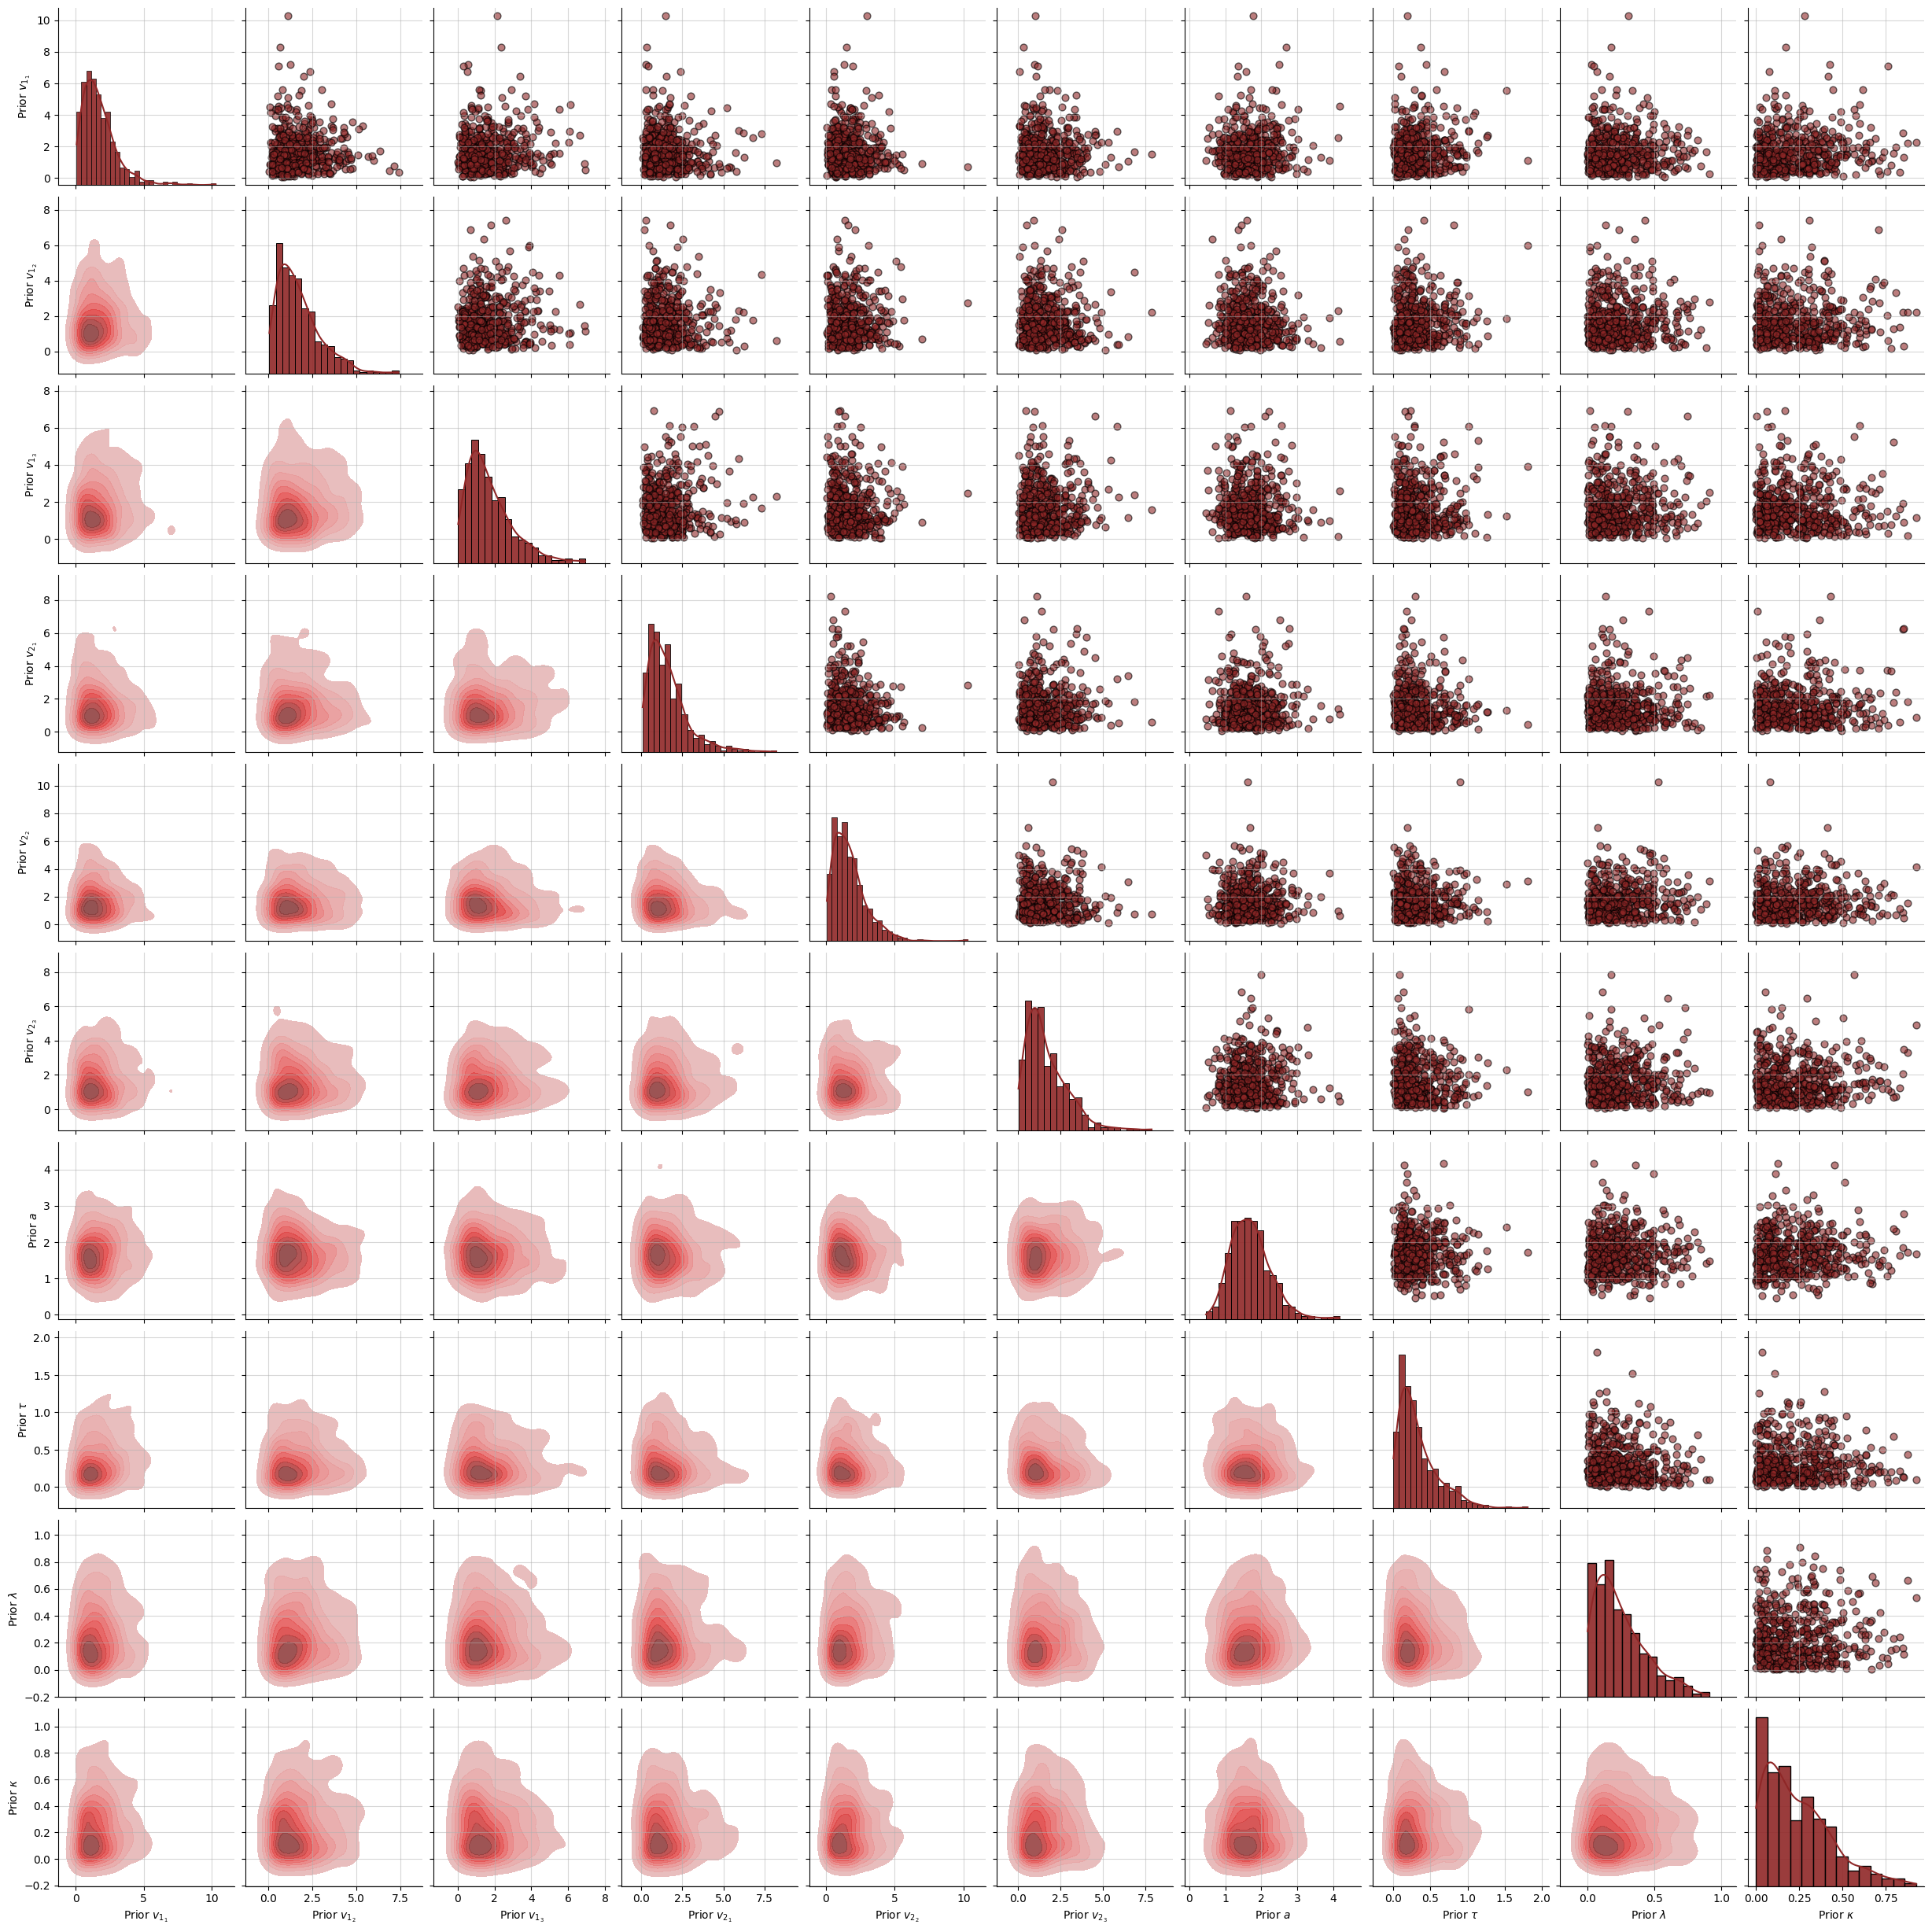

In [9]:
f = prior.plot_prior2d(n_samples=500)

### Context

A generative model, in addition to prior and simulator, also incorporates various contextual factors that affect the data generation process. These contextual assumptions are often specific to the field of study and can include elements such as experimental conditions, number of observations, and subject-specific factors.

`BayesFlow` distinguishes between two types of context variables: `batchable_context` and `non_batchable_context`. This distinction is purely technical, rather then conceptual:
* Batchable context variables differ for each simulation in each training batch of simulations;
* Non-batchable context variables stay the same for each simulation in a batch, but differ across simulated batches;

Examples for **batchable** context variables include experimental design variables, design matrices, etc.
Examples for **non-batchable** context variables include the number of observations in an experiment, positional encodings, time indices, etc. While the latter can also be considered batchable in principle, batching them would require non-Tensor (i.e., non-rectangular) data structures, which usually means inefficient computations. 

For this tutorial, I want to define one non_batchable and one batchable context variable that both affect the data simulator function but not the prior function. Let us imagine a hypothetical three-alternative decision-making task. In this task, two different stimuli are shown. We assume that this experimental manipulation affects the rate of evidence accumulation of the three accumulators. To simulate this experimental manipulation, we can define a function that creates randomly interleaved conditions for an experiment with let's say $500$ trials. This condition variable is batchable, because it does not change the data structure within a batch.

In practice, it's common to encounter missing trials in psychological research due to various reasons such as participant's lapses or experimental errors. Therefore, it's also important to train our networks with varying number of observations. This approach will make sure that the model can also be fit to data sets with missing data. Let us create a function that randomly samples a number of observations between $450$ and $500$. This condition variable is not batchable because if we have different number of observations within a batch then we don't get a rectangular multi-dimensional array of `size=(batch_size, n_obs)`.

In [13]:
MAX_OBS = 500
MIN_OBS = 450
N_CONDITIONS = 2

In [14]:
# non_batchable_context
def random_n_obs(min_obs=MIN_OBS, max_obs=MAX_OBS):
    return np.random.randint(min_obs, max_obs)

In [15]:
# batchable_context
def generate_condition_matrix(n_obs, n_conditons=N_CONDITIONS):
    obs_per_condition = np.ceil(n_obs / n_conditons)
    condition = np.arange(n_conditons)
    condition = np.repeat(condition, obs_per_condition)
    np.random.shuffle(condition)
    return condition[:n_obs]

Let us pass the ``generate_condition_matrix`` and the ``random_n_obs`` function to BayesFlow's ``ContextGenerator`` wrapper. In order to use the output of the ``random_n_obs`` function, which is the number of observations, and is needed by the ``generate_condition_matrix`` function, we have to set the ``use_non_batchable_for_batchable`` argument to ``True``.

In [16]:
context_gen = bf.simulation.ContextGenerator(
    non_batchable_context_fun=random_n_obs,
    batchable_context_fun=generate_condition_matrix,
    use_non_batchable_for_batchable=True)

In [17]:
context_gen(2)

{'non_batchable_context': 461,
 'batchable_context': [array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
         0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
         0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
         0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
         1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
         0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
         1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 

As you can see, the randomly sampled number of observation is constant within a batch of 2 simulated experimental contexts but the order of the experimental conditions is different between the contexts.

### Simulator

Next, we create a function that repeatetly calls the ``lca_trial`` function to simulate the performance of a single subject in a whole experiment given a set of parameter values and context variables. Again, we use the ``@njit`` decorator to improve the speed of the core data simulation function, which will be heavily used during training.

In [17]:
@njit
def lca_experiment(theta, context, *args):
    n_obs = int(context.shape[0])
    n_cond = len(np.unique(context))
    n_alt = int((len(theta) - 4 ) / n_cond)
    v = theta[:n_alt*n_cond]
    v = np.split(v, n_cond)
    out = np.zeros((n_obs, 2))
    for n in range(n_obs):
        out[n, :] = lca_trial(v[context[n]], theta[-4], theta[-3], theta[-2], theta[-1])
    return out

Lets pass the ``lca_experiment`` function and the context generator to BayesFlows ``Simulator`` wrapper.

In [18]:
simulator = bf.simulation.Simulator(
    simulator_fun=lca_experiment,
    context_generator=context_gen)

We have now defined all the building blocks of a generative model, namely a randomized data generator, prior distributions, and a experimental context. We can now combine all the parts to form a generative model by using BayesFlow's ``GenerativeModel`` class.

In [19]:
model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=simulator,
    name='LCA')

INFO:root:Performing 2 pilot runs with the LCA model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 463, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Could not determine shape of simulation non-batchable context. Type appears to be non-array: <class 'int'>,                                    so make sure your input configurator takes cares of that!
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!


Let us simulate a batch of $10$ data sets with $10$ randomly sampled parameter sets and generated contexts.

In [ ]:
model(batch_size=10)

We get a dictionary with all what we need:
* prior draws
* batchable and non-batchable context
* simulated data

## Prior Push Forward Check

Now, that we have specified a fully-flegded cognitive model we want to check whether the generative model with its (prior) assumptions produces sensible data that could be oberseved in the real world. To this end, we just simulate some data sets and inspect the joint response time distribution.

In [21]:
sim_out = model(batch_size=10)

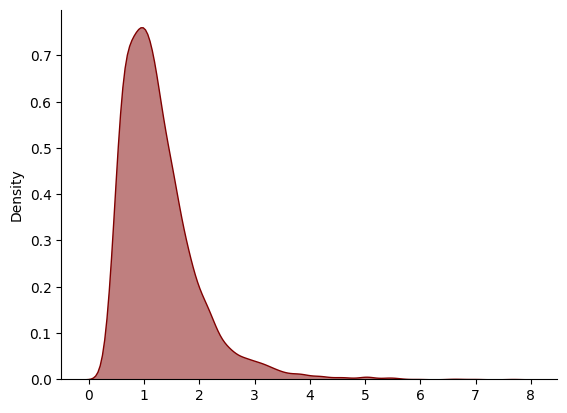

In [25]:
sns.kdeplot(sim_out['sim_data'][:, :, 0].flatten(), fill=True, color='maroon', alpha=0.5)
sns.despine()

We observe a skewed distribution which is commonly observed in empricial response time data. We also do not detect any unusual or implausible values such as negative response times or excessively high values.

The next step in our workflow is to conduct prior predictive checks. This involves fitting our LCA model to simulated data and then using the obtained parameters to predict these data through resimulation. Before we can proceed with this step, we first need to train our neural networks.

## Defining the Neural Approximator

### Summary Network

Although we simulate randomly interleaved experimental manipulation, we are not really interested in any sequential effects during the hypothetical decision task. Therefore, we can treat our data as exchangeable and use an ``InvariantNetwork`` for the summary network. This invariant neural network respects the permutation invariance of the data. It takes (at least) 3D tensors of shape ``(batch_size, n_obs, data_dim)`` and reduce them to 2D tensors of shape ``(batch_size, summary_dim)``, where ``summary_dim`` is a hyperparameter to be set by us. Heuristically, this number should not be lower than the number of parameters in a model. Below, we create an invariant network with ``summary_dim = 32``:

In [26]:
summary_net = bf.networks.InvariantNetwork(summary_dim=32)

### Inference Network

The conditional invertible neural network (cINN) is the key component of our amortized posterior inference framework. The only required hyperparameter for the cINN is the number of parameters to be estimated. However, other hyperparameters, such as the number of coupling layers, can also be adjusted. In our example, we set ``num_coupling_layers = 5``.

In [27]:
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names), num_coupling_layers=5)

### Amortized Posterior

We can now connect the summary and inference networks via the ``AmortizedPosterior`` wrapper:

In [61]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='lca_amortizer')

## Defining the Configurator

A configurator acts as an intermediary between a generative model and an amortizer. Here we should do mainly two things:
1. Bring the output of the generative model (simulated data, context, prior draws) into a suitable format for processing with neural networks.
2. Transformations of data and/or parameters.

In the following we will do both. Firsty, our simulated data has two dimensions ``(n_obs, data_dim)``. ``data_dim = 2`` consists of response times and choices. The choice variable is categorical and can be either $0$, $1$, or $2$, because there are three alternatives in the imagined decision task. When working with neural networks, categorical variables always have to be one-hot encoded (dummy-coded). In addition, we also have to pass the context information to the neural networks. As we only have two conditions this variable is already dummy coded and we simply add it to the two dimensional data array. This will extend the ``data_dim`` to $5$ (one for rts, three for responses, one for context).

Secondly, we also want to standardize the data generating parameters before we pass them to the neural network.

In order to standardize the parameters we need the mean and standard deviation of our prior distributions. We can get them with another handy method from BayesFlow's ``prior`` class.

In [62]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=100000)
prior_means = np.round(prior_means, decimals=1)
prior_stds = np.round(prior_stds, decimals=1)

In [64]:
from keras.utils import to_categorical

def configurator(forward_dict): 
    # Prepare placeholder dict
    out_dict = {}

    # Get simulated data and context
    data = forward_dict['sim_data']
    context = np.array(forward_dict['sim_batchable_context'])[:, :, np.newaxis]
    # one-hot encoding choices
    categorical_resp = to_categorical(data[:, :, 1])
    # concatenate rt, resp, context
    out_dict['summary_conditions'] = np.c_[data[:, :, :1], categorical_resp, context].astype(np.float32)

    # Get data generating parameters
    params = forward_dict['prior_draws'].astype(np.float32)
    # Standardize parameters
    out_dict['parameters'] = (params - prior_means) / prior_stds

    return out_dict

## Defining the Trainer

Now it is time to define the ``Trainer`` instance. We simply pass the generatvie model, the amortizer, and our configurator. Usually we want to define a ``checkpoint_path``, so the neural approximator will be saved automatically to this path. Otherwise, neural approximators must be manually saved using, for instance, TensorFlow's `amortizer.save_weights()` method.

In [65]:
trainer = bf.trainers.Trainer(
    generative_model=model,
    amortizer=amortizer,
    configurator=configurator,
    # checkpoint_path='/checkpoints/lca_model'
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


When we initiate the trainer it informs us whether a consistency check (i.e., simulation -> configuration -> transformation -> loss computation) was successful. In our case, we passed the check and are now ready to train our neural networks.

We can also check out the number of trainable neural network parameters for the composite approximator:

In [66]:
amortizer.summary()

Model: "lca_amortizer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Inverti  multiple                 440620    
 bleNetwork)                                                     
                                                                 
 invariant_network (Invarian  multiple                 69280     
 tNetwork)                                                       
                                                                 
Total params: 509,900
Trainable params: 509,800
Non-trainable params: 100
_________________________________________________________________


## Training Phase

With the help of ``numba`` our simulator is relatively fast. Thus, we can safely go with online training. Let's glean the time taken for a batch of $32$ simulations:

In [67]:
%%time
_ = model(32)

CPU times: user 1.03 s, sys: 3.84 ms, total: 1.03 s
Wall time: 1.03 s


We will train for $10$ epochs using $500$ iterations of $32$ simulations which amounts to a total of $50 \times 500 \times 32 = 800000$ simulations performed. Note, that since we are using online training, overfitting is highly unlikely. Otherwise, we recommend using a validation set of simulations through the `validation_sims` keyword argument.

In [ ]:
h = trainer.train_online(epochs=50, iterations_per_epoch=500, batch_size=32)

### Inspecting the Loss

Following our online simulation-based training, we can quickly visualize the loss trajectory using the `plot_losses` function from the `diagnostics` module.

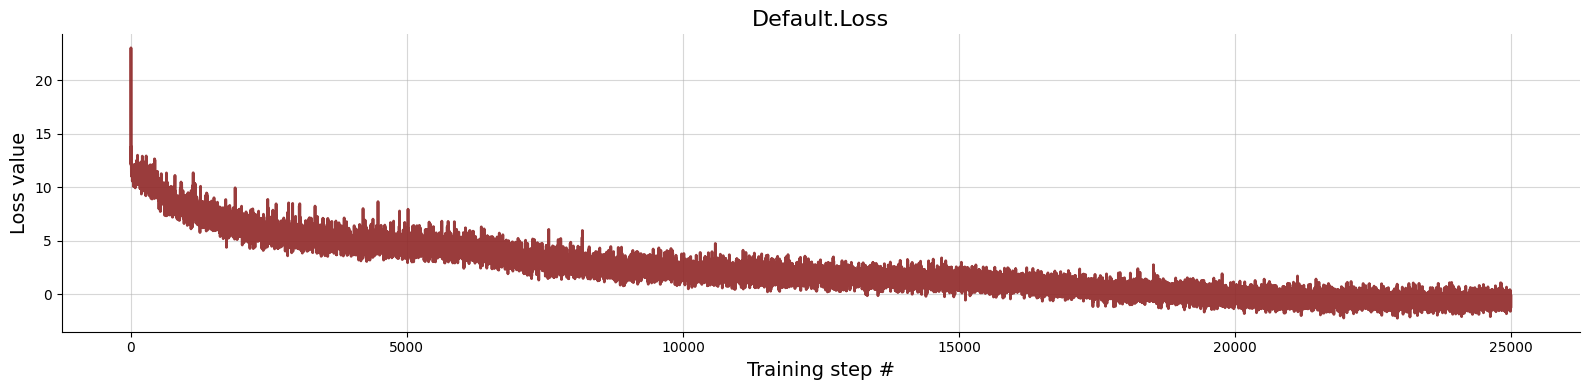

In [70]:
f = bf.diagnostics.plot_losses(h)

At some point the loss stopped decreasing which indicates that there is not much to learn from further simulation and we can continue with some diagnostics.

### Inspecting the Latent Space

A quick and useful diagnostic is to check whether the marginal latent distribution $p(\boldsymbol{z})$ has the prescribed probabilistic structure. Since, by default, we optimize the amortizer with the Kullback-Leibler (KL) loss (also known as maximum likelihood training, which is not to be confused with maximum likelihood estimation!), we expect to observe approximately Gaussian latent space with independent axes. Moreover, since the trainer also keeps an internal `SimulationMemory` instance, we can also directly call it's `diagnose_latent2d` method (also available in the `diagnostics` module):

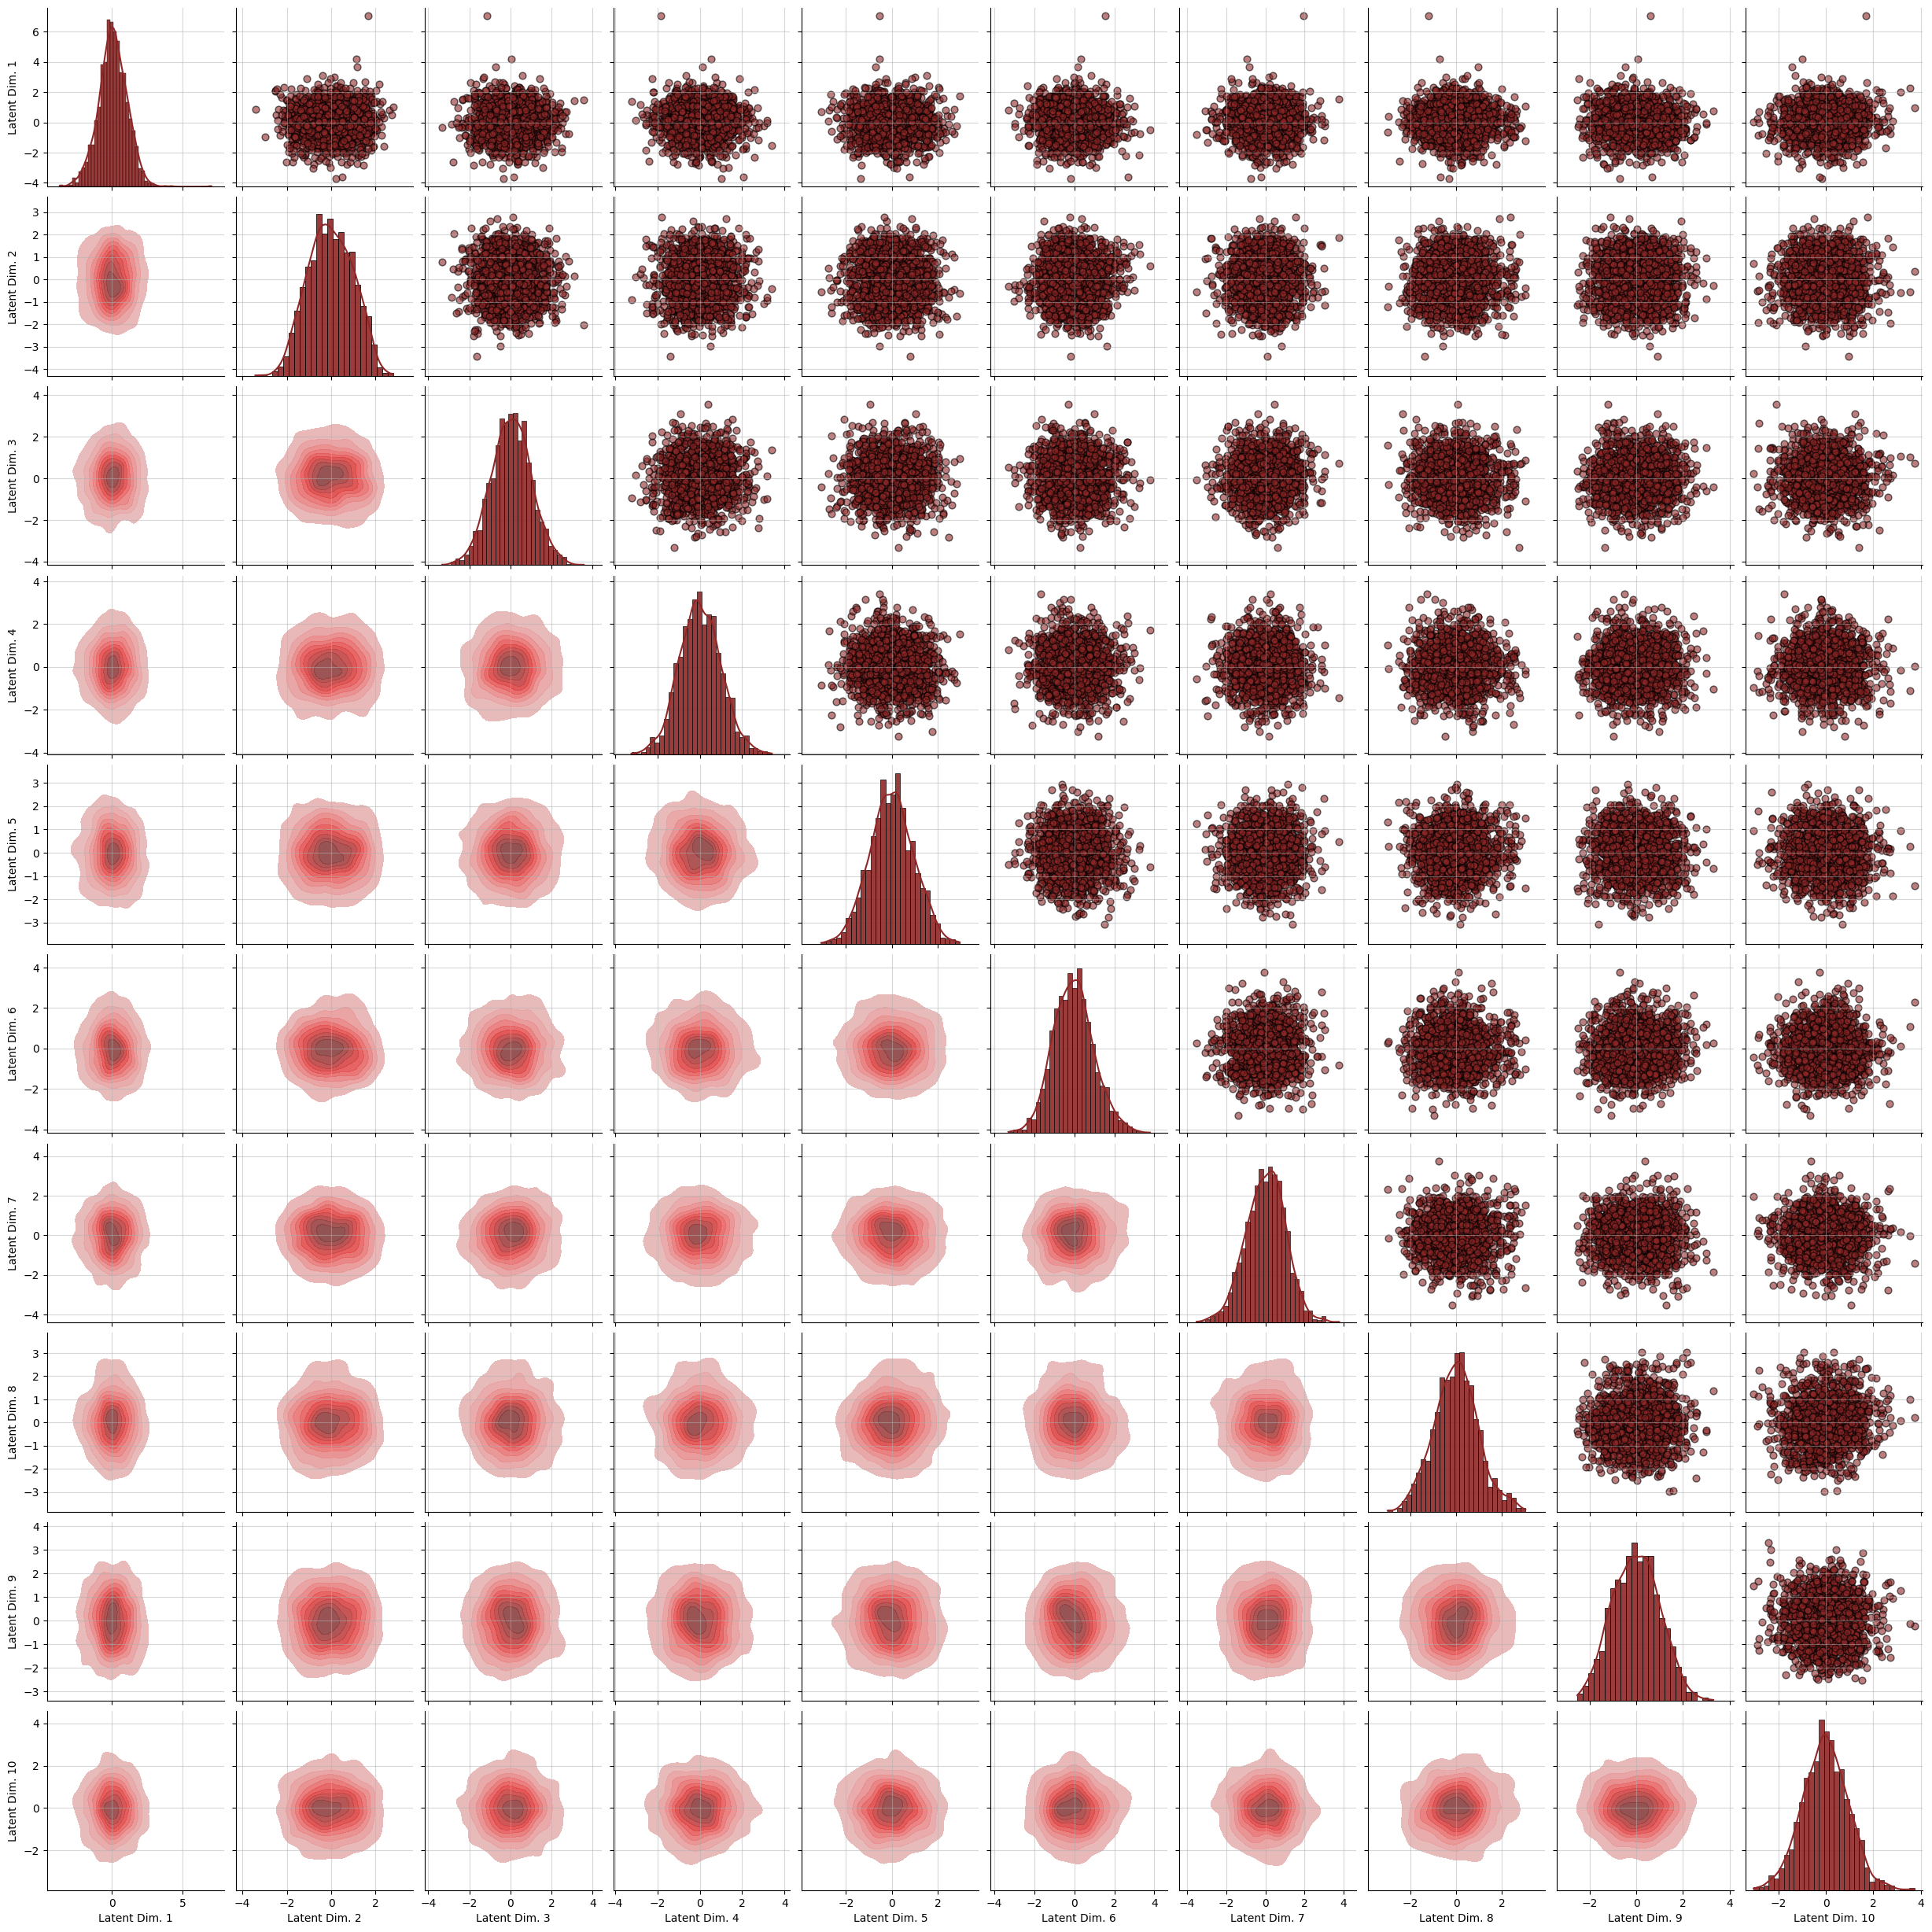

In [71]:
f = trainer.diagnose_latent2d()

## Prior Predictive Checks

Alright, let us continue with prior predictive checks. To this end, we do the following steps:

1. Simulate data with our generative model.
2. Fit the model to these data.
3. Resimulate new data with samples from the obtained posterior.
4. Compare summary of the simulated data and the resimulated data (model prediction).

Note, that is exactly the same procedure as for posterior retrodictive checks except that we use simulated instead of empirical data.

Let us assess the predictive performance on 4 simulated data sets. We will obtain 1000 posterior samples and resimulated data with 50 parameter sets randomly sampled from the posterior for each data set separately.

In [72]:
num_sim = 4
num_samples = 1000
num_resim = 50

**Step 1**

In [73]:
sim_data = trainer.configurator(model(batch_size=num_sim))
num_obs = sim_data['summary_conditions'].shape[1]

**Step 2**

In [74]:
# fit model
post_samples = amortizer.sample(sim_data, n_samples=num_samples)
# unstandardize posteriors
post_samples_not_z = post_samples * prior_stds + prior_means

**Step 3**

In [75]:
# generate random index for posterior parameter set selection
index = np.random.choice(np.arange(num_samples), size=num_resim)
# get context of simulated data sets
context = np.argmax(sim_data['summary_conditions'][:, :, 2:], axis=2)
# resimulate
pred_data = np.zeros((num_sim, num_resim, num_obs, 2))
for sim in range(context.shape[0]):
    for i, idx in enumerate(index):
        pred_data[sim, i, :, :] = lca_experiment(post_samples_not_z[sim, idx, :], context[sim])

**Step 4**

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

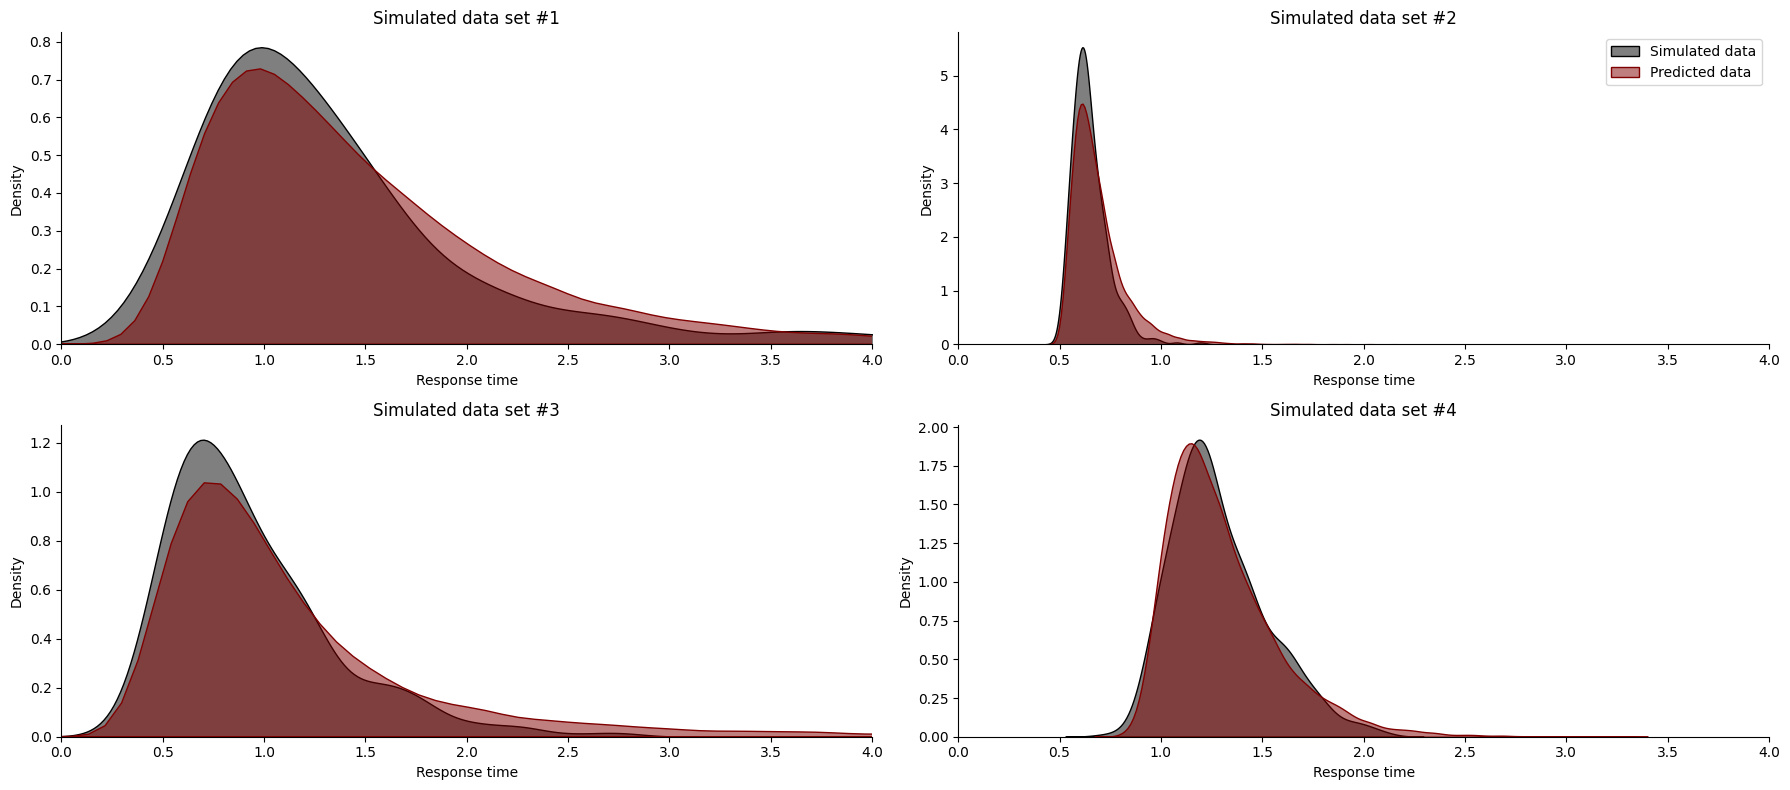

In [77]:
f, axarr = plt.subplots(2, 2, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    sns.kdeplot(sim_data['summary_conditions'][i, :, 0], ax=ax, fill=True, color='black', alpha=0.5, label='Simulated data')
    sns.kdeplot(pred_data[i, :, :, 0].flatten(), ax=ax, fill=True, color='maroon', alpha=0.5, label='Predicted data')
    ax.set_xlim((0, 4))
    ax.set_xlabel('Response time')
    ax.set_title(f'Simulated data set #{i+1}')
    if i == 1:
        ax.legend()
    sns.despine()
    f.tight_layout()

Comparing the kernel densities between the simulated and predicted response times shows that we can fit synthetic data reasonably well.
Hence, let us continue with further validation.

## Simulation-Based Calibration

As a further small world (i.e. before seeing real data) check, we have to test the computational faithfulness of our amortizer. We do this with simulation-based calibration (SBC; for more details see, [Talts et al. 2018](https://arxiv.org/abs/1804.06788); [Säilynoja et al. 2021](https://arxiv.org/abs/2103.10522)).

Again, ``BayesFlow`` has us covered with some great functions to compute and visualize the calibration.

### Rank Histograms

If we are able to obtain unbiased posterior distributions, we should observe approximately uniform rank statistic histograms

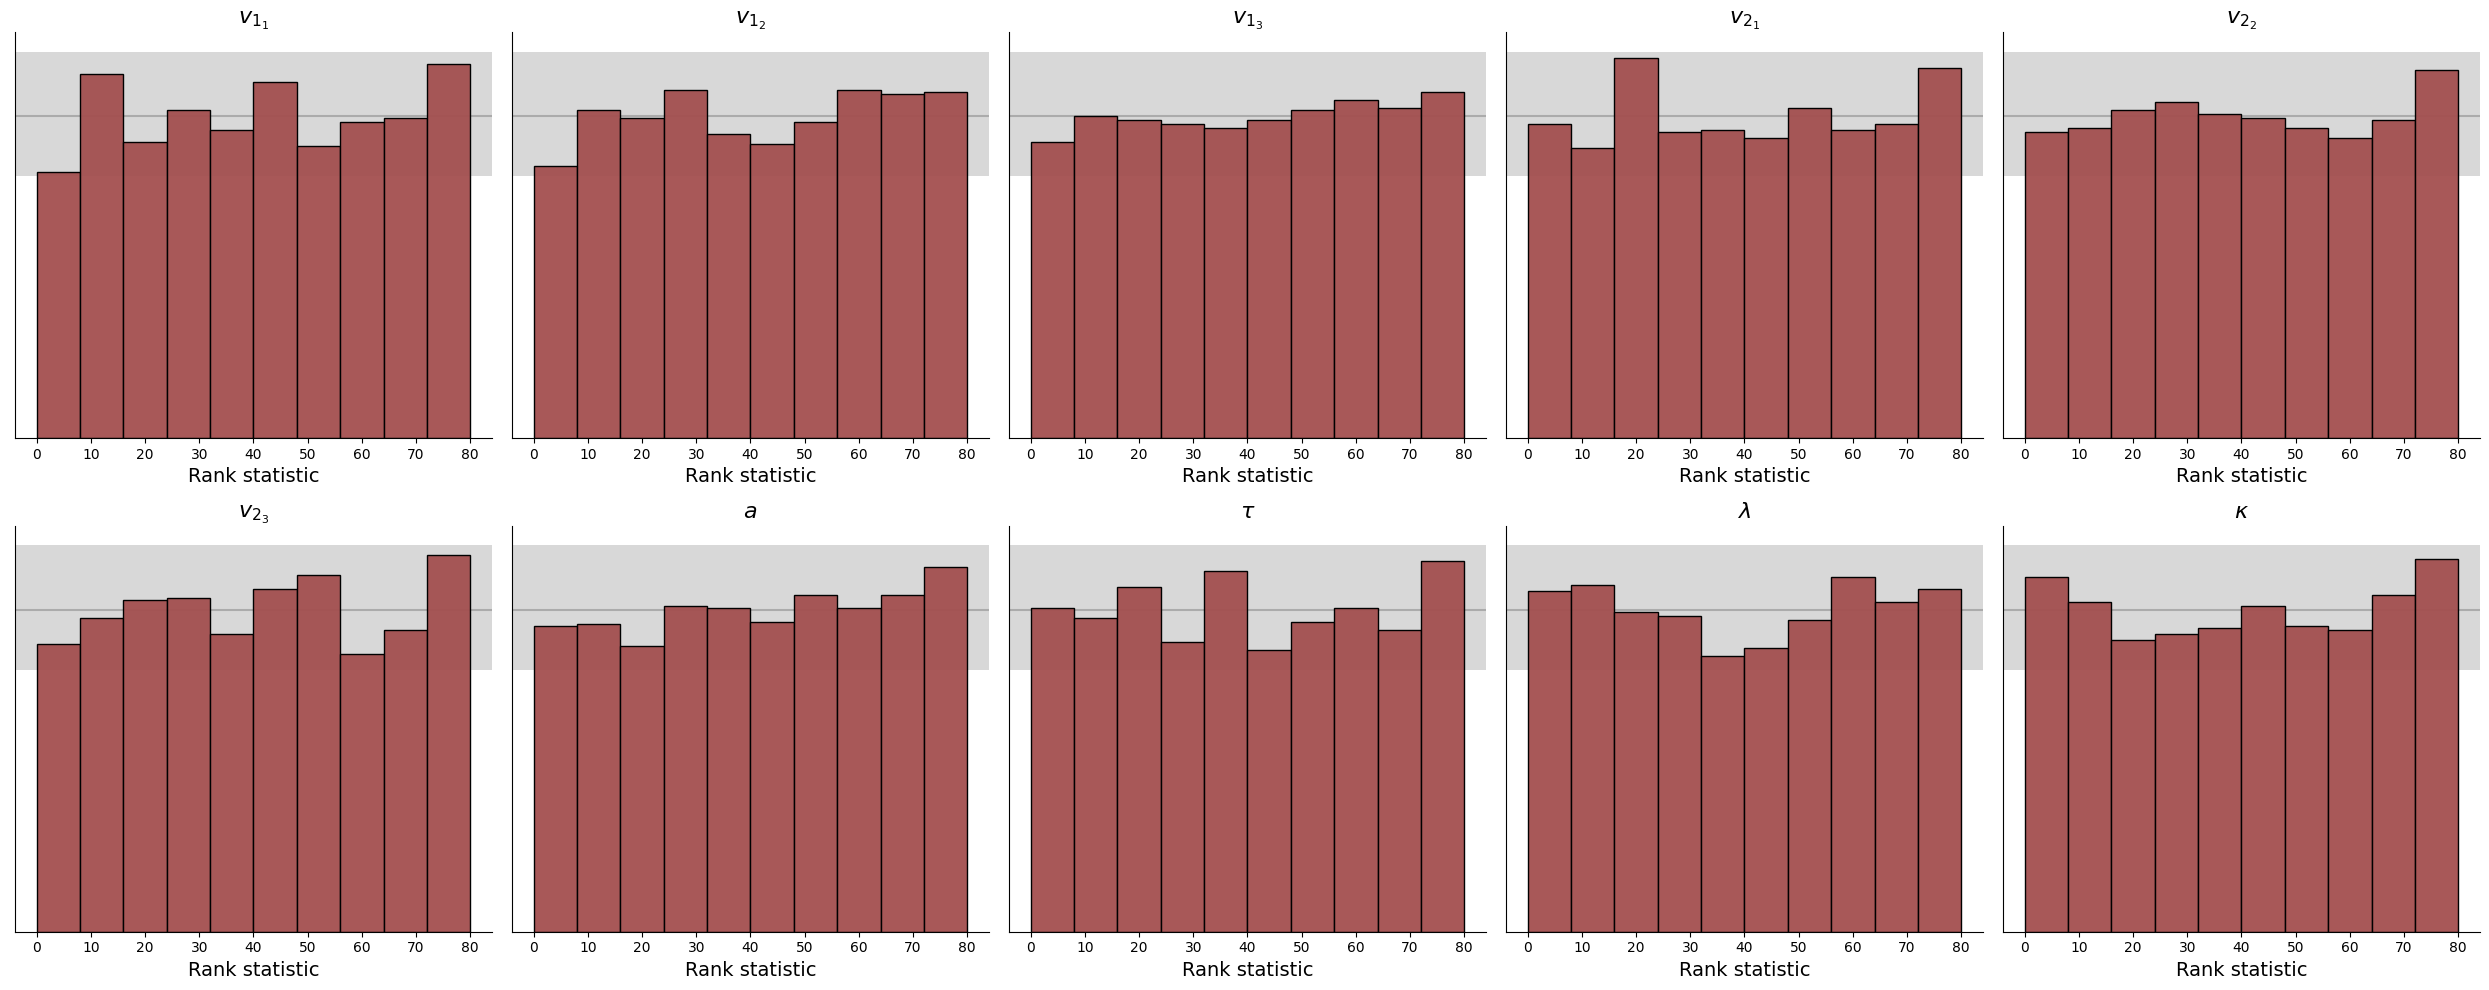

In [78]:
f = trainer.diagnose_sbc_histograms()

### Rank ECDF

For models with many parameters, inspecting many histograms can become unwieldly. Moreover, the `num_bins` hyperparameter for the construction of SBC rank histograms can be hard to choose. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics.

For SBC I always opt for at least a 10:1 ratio between number of simulations and number of posterior samples

In [88]:
# Generate some validation data
validation_sims = trainer.configurator(model(batch_size=1000))

# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=50)

With `stacked=True` we can produce stacked ECDFs and `difference=True` with compute ECDF differences for a more dynamic visualization range.

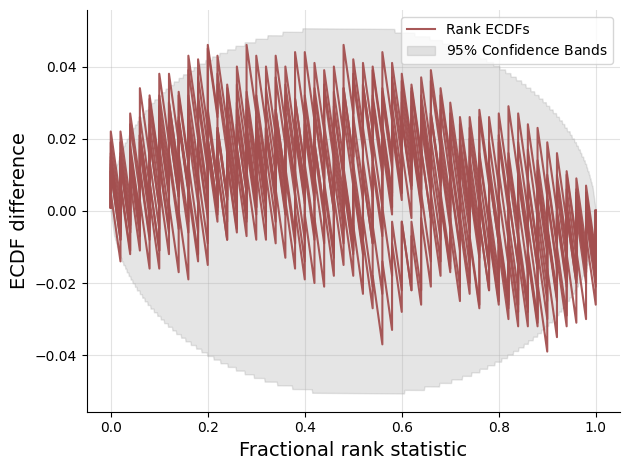

In [89]:
# Create ECDF plot
f = bf.diagnostics.plot_sbc_ecdf(post_samples, validation_sims['parameters'], stacked=True, difference=True, legend_fontsize=10)

Hooray, both method show that our approximator is more or less well calibrated!

## Inferential Adequacy

Being able to recover the true data generating parameters is very important in cognitive modeling. If we a parameter cannot be recovered with reasonable precision then we are not allowed to make any psychological interpretation based on the estimate of this parameter. Further, we can consider to remove this parameter from the model.

We can test this *in silico* via the `plot_recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter. Below, we re-use the $1000$ simulations we generated for computing the rank ECDFs, but obtain a larger number of posterior draws per data set for more stable results:

In [81]:
post_samples = amortizer.sample(validation_sims, n_samples=500)

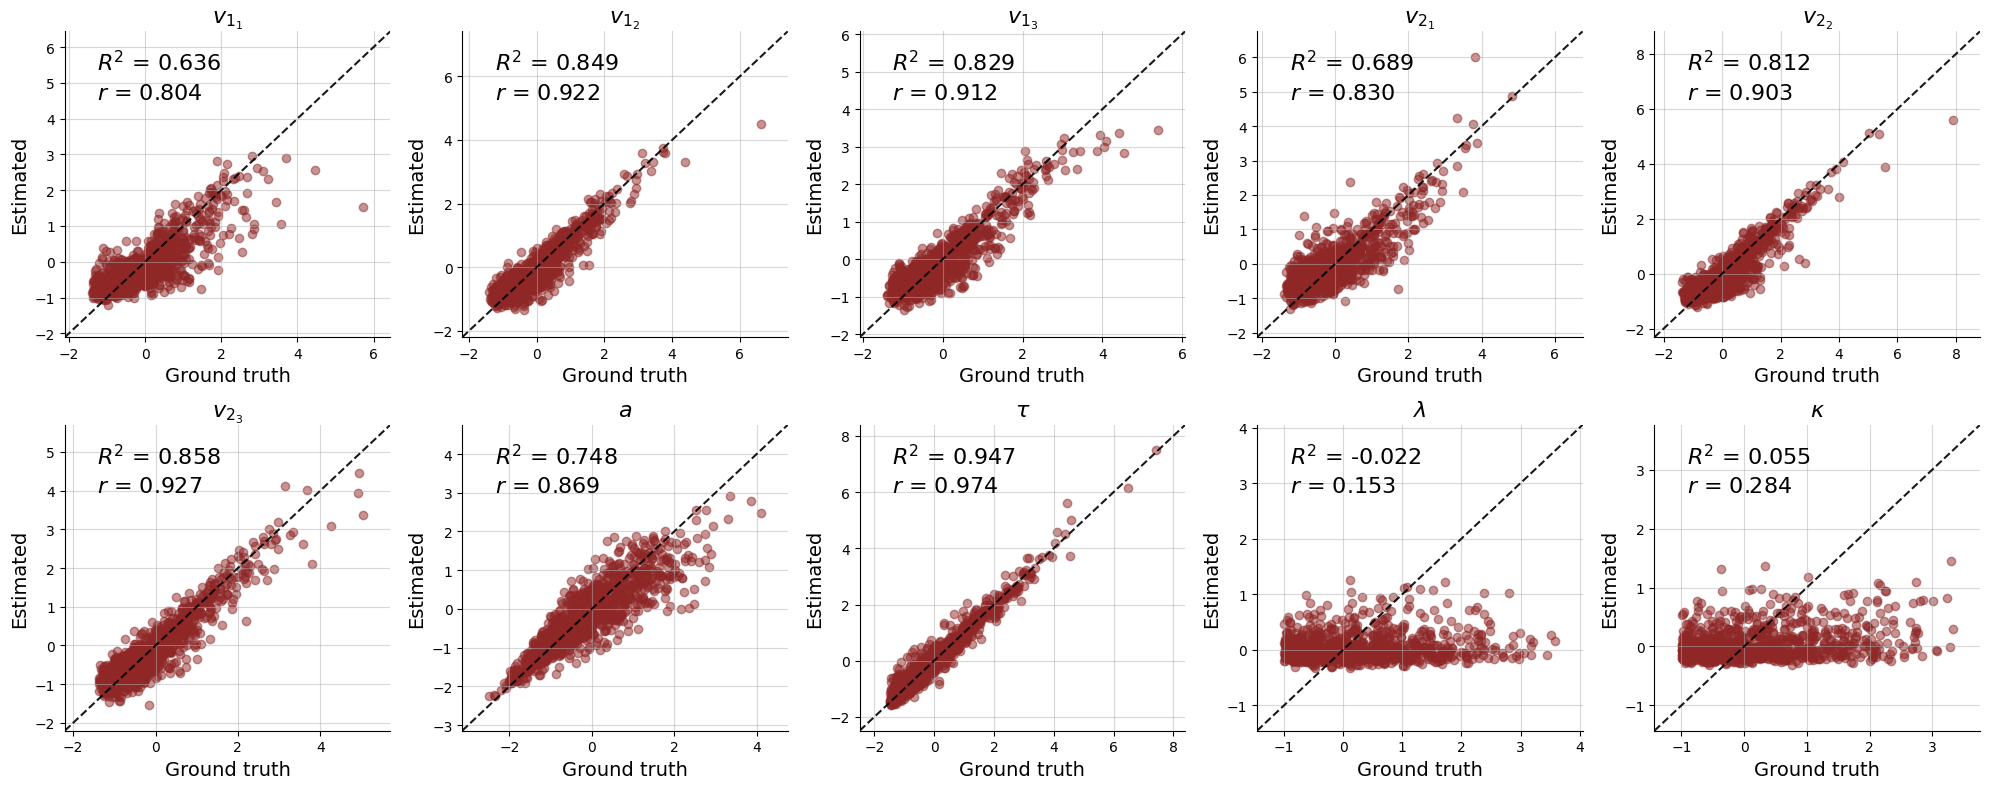

In [82]:
f = bf.diagnostics.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names, uncertainty_agg=None)

All parameters but the decay parameter $\lambda$ and the inhibition parameter $\kappa$ can be recovered with reasonable precision. This is not a suprising result as studies have shown that $\lambda$ and $\kappa$ are notoriously hard to recover.

## Inference Phase

The next step would usually be to fit the model to real empirical data and check whether the model accurately predicts the data at hand. To this end, we perform posterior retrodiction checks. As I do not have empirical data for a 3 three alternative decision-making task I will cover this step on a conceptual level.

1. Read the data
2. Bring the data into the same form as the simulated data we used for training the network. In our case this would mean, a multi-dimensional array with `shape = (n_sub, n_obs, 5)`. The last dimension should be in the following order: Response time, one-hot encoded choice, condition.
3. Fit the model to the data (see Step 2 in prior predictive checks)
4. Predict new data (see Step 3 in prior predictive checks)
5. Visulize empiric and predicted data (see Step 4 in prior predictive checks)